# Problem Statement

Our client wants to identify key predictors of whether a user will convert (purchase a product) so they can optimize their marketing campaign strategies and website conversion funnel. 


Load libraries, and then take a look at the data

In [4]:
library(dplyr)
library(tidyverse)
library(DMwR2)
library(caret)
library(ggplot2)
library(GGally)
library(rpart.plot)

The dataset came from UC Irvine Machine Learning Repository and was obtained from this URL: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

Data contains 12,330 sessions, with 10 numerical and 8 categorical attributes about user behavior, demographics and purchase values.

The dataset was formed so that each session would belong to a different user in a 1-year period to avoid any tendency to a specific campaign, special day, user profile, or period.

In [11]:
data = read.csv("online_shoppers_intention.csv")
df <- data %>% glimpse()

Rows: 12,330
Columns: 18
$ Administrative          <int> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2…
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5…
$ Informational           <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ ProductRelated          <int> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, 2…
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.5…
$ BounceRates             <dbl> 0.200000000, 0.000000000, 0.200000000, 0.05000…
$ ExitRates               <dbl> 0.200000000, 0.100000000, 0.200000000, 0.14000…
$ PageValues              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ SpecialDay              <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.8, 0…
$ Month                   <chr> "Feb", "Feb", "Feb", "Feb", "Feb", "Feb", "Feb…
$ OperatingSystems        <int> 1, 2, 4, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 1…
$ Browser      

We need to perform standard data cleaning such as:
1. Change categories to factors.
2. Remove BounceRate, ExitRates and PageValues because those would be highly correlated to conversion rates
3. Remove Special Day and instead turn it into a factor, to avoid nearZeroVar

We'll also create some caclulations (features):
- Total Duration = Total duration across all page types
- Total Pages = Total pages across all page types

In [12]:
df <- data %>% mutate(Revenue = as.factor(Revenue),
                      OperatingSystems = as.factor(OperatingSystems),
                      Browser = as.factor(Browser),
                      Region = as.factor(Region),
                      VisitorType = as.factor(VisitorType),
                      TrafficType = as.factor(TrafficType),
                      Weekend = as.factor(ifelse(Weekend == TRUE, 1, 0)),
                      Month = as.factor(recode(Month, Feb = 2,Mar = 3,May = 5,June = 6,Jul = 7,
                                               Aug = 8,  Sep = 9,Oct = 10,Nov = 11,Dec = 12)),
                      #totals
                      TotalDuration = Informational_Duration
                                      + ProductRelated_Duration + Administrative_Duration,
                      TotalPages =  Informational + ProductRelated + Administrative,

                      #binaries
                      Revenue_binary =  ifelse(Revenue == TRUE, 1, 0),
                      VisitorType_Returning_binary = ifelse(VisitorType == "Returning_Visitor", 1, 0),
                      Weekend_binary = ifelse(Weekend == 1, 1, 0),
                      ProductRelated_binary = ifelse(ProductRelated_Duration > 0, 1, 0),
                      Administrative_binary = ifelse(Administrative_Duration > 0, 1, 0),
                      Informational_binary = ifelse(Informational_Duration > 0, 1, 0))

df <-  df %>% mutate(special_day_binary = (
                        case_when(SpecialDay == 0 ~ 1, .default = 0)))

df_fact <- df %>% select(-Revenue_binary, -Weekend_binary, -TrafficType, -PageValues, -BounceRates, -ExitRates, -SpecialDay,-VisitorType_Returning_binary) %>% mutate(special_day_binary = as.factor(special_day_binary))
df_fact <- df_fact %>% filter(VisitorType != "Other")

df_fact %>% glimpse()

Rows: 12,245
Columns: 19
$ Administrative          <int> 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2…
$ Administrative_Duration <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5…
$ Informational           <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Informational_Duration  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ ProductRelated          <int> 1, 2, 1, 2, 10, 19, 1, 0, 2, 3, 3, 16, 7, 6, 2…
$ ProductRelated_Duration <dbl> 0.000000, 64.000000, 0.000000, 2.666667, 627.5…
$ Month                   <fct> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…
$ OperatingSystems        <fct> 1, 2, 4, 3, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 1…
$ Browser                 <fct> 1, 2, 1, 2, 3, 2, 4, 2, 2, 4, 1, 1, 1, 5, 2, 1…
$ Region                  <fct> 1, 1, 9, 2, 1, 1, 3, 1, 2, 1, 3, 4, 1, 1, 3, 9…
$ VisitorType             <fct> Returning_Visitor, Returning_Visitor, Returnin…
$ Weekend                 <fct> 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0…
$ Revenue      

Running some quick sums, we can clearly see commonalities among converting sessions:
- Spent longer on the site 
- Visit more pages per user
- Visited on special days 
- Were returning users 

In [13]:
df_sum <- df %>% group_by(Revenue)  %>%
              summarize(total_count = n(),
              avg_duration = round(mean(TotalDuration),digits=2),
              sum_pages = round(sum(TotalPages),digits=2),
              page_per_user = sum_pages / total_count,
              weekend_true = sum(Weekend_binary),
              perc_weekend = round((weekend_true / total_count),digits = 2 ),
              returning = sum(case_when(VisitorType == "Returning_Visitor" ~ 1, .default = 0)),
              new = sum(case_when(VisitorType == "New_Visitor" ~ 1, .default = 0)),
              perc_returning = round(returning / sum(returning + new),digits = 2),
              special_day_total = sum(special_day_binary),
              perc_on_special_day =   round((special_day_total / total_count),digits=2))

df_sum %>% select(1:3,5,7,8:10,12)

Revenue,total_count,avg_duration,page_per_user,perc_weekend,returning,new,perc_returning,perc_on_special_day
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,10422,1173.96,31.28421,0.23,9081,1272,0.88,0.89
TRUE,1908,2053.30,52.38994,0.26,1470,422,0.78,0.96


Can we spot any correlations between conversion rate and any of the following dimensions?
- Operating Systems
- Region
- Month 
- Total Pages

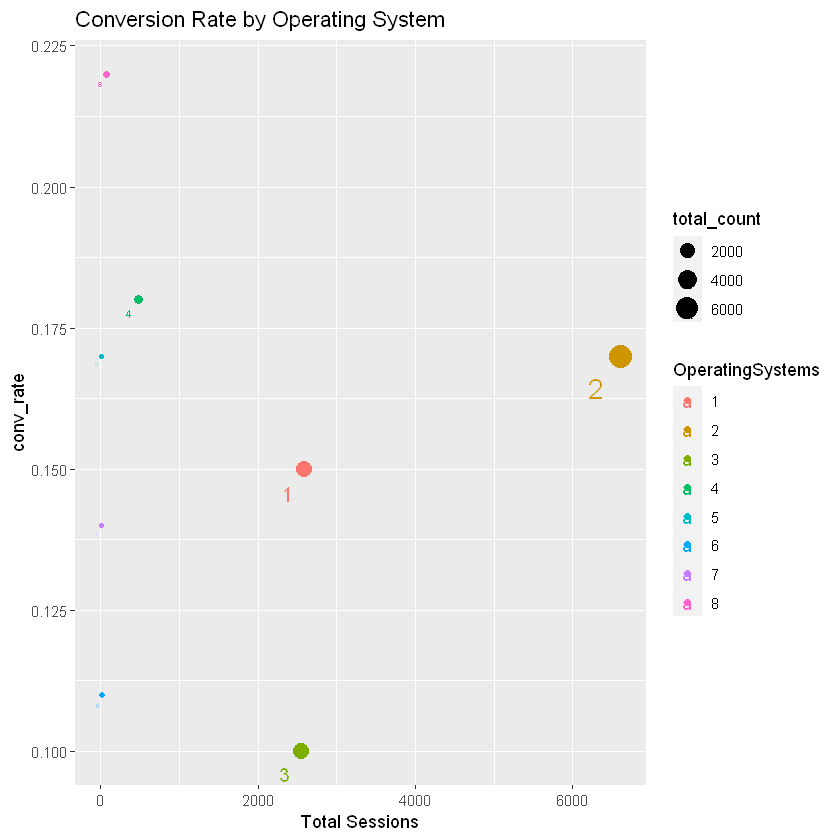

In [17]:
df_sum_op <- df %>% group_by(OperatingSystems)  %>%
 dplyr:: summarize(rev_true = sum(Revenue_binary),
            total_count = n(),
            conv_rate = round((rev_true / total_count), digits=2))

ggplot(df_sum_op, aes(x = total_count, y = conv_rate, color = OperatingSystems, size=total_count, label=OperatingSystems )) +
  geom_point() + geom_text(hjust=2,vjust=2) + labs(title ="Conversion Rate by Operating System", x ="Total Sessions")

Operating Systems:



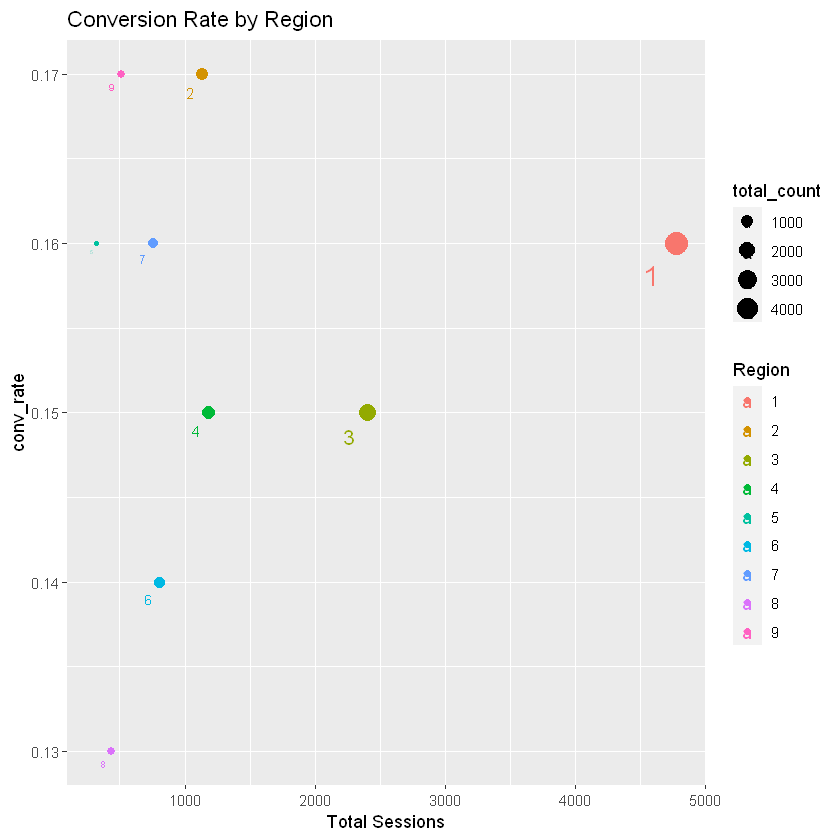

In [21]:
df_sum_reg <- df %>% group_by(Region)  %>%
  dplyr::summarize(rev_true = sum(Revenue_binary),
            total_count = n(),
            conv_rate = round((rev_true / total_count), digits=2))

ggplot(df_sum_reg, aes(x = total_count, y = conv_rate, color = Region, size=total_count, label=Region )) +
  geom_point() + geom_text(hjust=2,vjust=2) + labs(title ="Conversion Rate by Region", x ="Total Sessions")


Region 1 and 3 are the most noteworthy

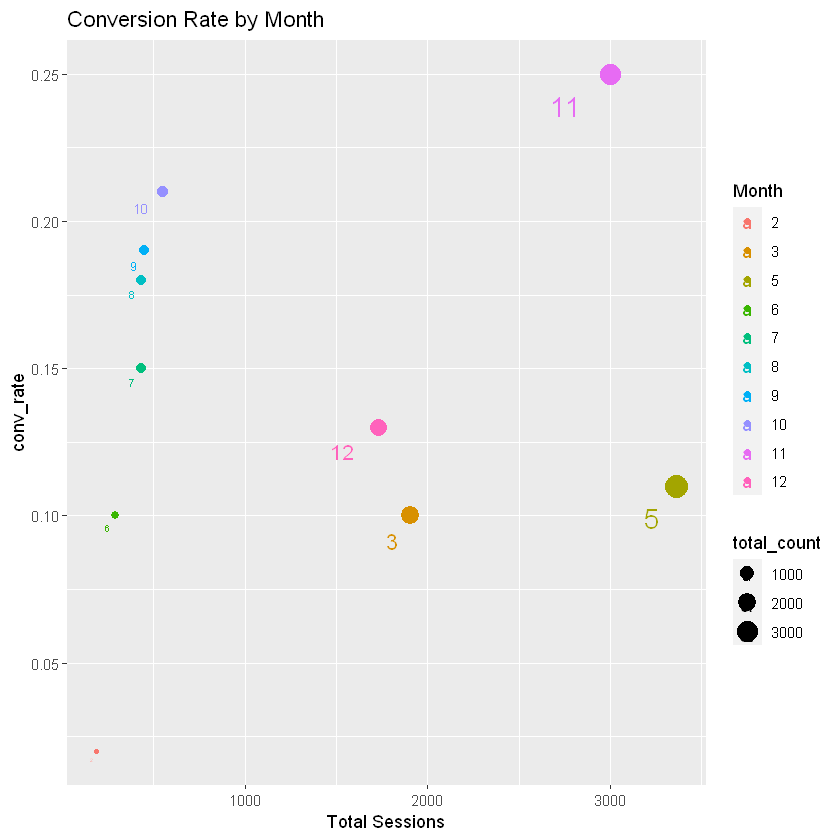

In [19]:
df_sum_mo <- df %>% group_by(Month)  %>%
  dplyr::summarize(rev_true = sum(Revenue_binary),
            total_count = n(),
            conv_rate = round((rev_true / total_count), digits=2))

ggplot(df_sum_mo, aes(x = total_count, y = conv_rate, color = Month, size=total_count, label=Month)) +
  geom_point() + geom_text(hjust=2,vjust=2)   + labs(title ="Conversion Rate by Month", x ="Total Sessions")


- Month 11 had the highest conversion rate and the most sessions.
- Month 3, 5, and 12 also are noteworthy
- Maybe month will be an important feature.

Warning message:
"Removed 213 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"The following aesthetics were dropped during statistical transformation: colour
ℹ This can happen when ggplot fails to infer the correct grouping structure in the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical variable into a factor?"
Warning message:
"Removed 213 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 214 rows containing missing values (`geom_point()`)."


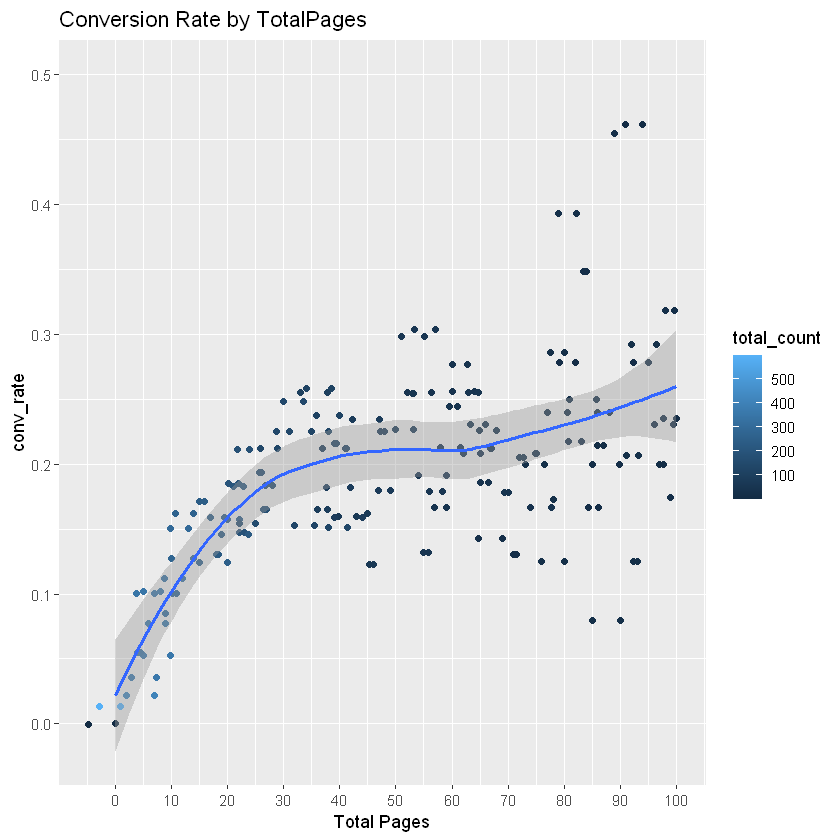

In [22]:
df_sum_tp <- df %>% group_by(TotalPages)  %>%
  dplyr::summarize(rev_true = sum(Revenue_binary),
            total_count = n(),
            conv_rate = rev_true / total_count)


ggplot(df_sum_tp, aes(x = TotalPages, y = conv_rate, color = total_count)) +
  geom_point()  +
  geom_jitter(width = 5) +
  geom_smooth(method = "loess", formula = y ~ x) +
  labs(title ="Conversion Rate by TotalPages", x ="Total Pages") +
  scale_x_continuous(n.breaks = 10,limits = c(NA,100)) +
       scale_y_continuous(n.breaks = 5,limits = c(NA,.5) )

DATA EXPLORATION: Conversion Rates

Trend shows more pages = higher conversion rate


# Normalize the data.

Note: I ran these models through twice: once with the preprocessed data (centered and scaled) and once without the preprocessing. 

Centering and scaling didn’t  make a signficant difference in model performance. And in fact, in the glm model, it hurt accuracy. So going forward, we'll use the datasets without the preprocessing.

In [24]:
set.seed(1234)
in_train = createDataPartition(y = df_fact$Revenue,
p = 0.8, list = FALSE)
r_train = df_fact[in_train, ]
r_test = df_fact[-in_train, ]
training_set = select(r_train, -Revenue)

preprocess_steps = preProcess(r_train, method = c("center","scale"))
r_train_proc = predict(preprocess_steps, newdata = r_train)
r_test_proc = predict(preprocess_steps, newdata = r_test)
training_set_proc = select(r_train_proc, -Revenue)

# Model selection

I explored 4 models to determine the best fitting model for our problem statement and dataset:
- Logistic Regression
- KNN
- Ranger
- Bagged

Let's set up each model, and then explore their feature selection and model accuracy before selecting the best fitting model and recommending next steps.

# Logistic Regression

- Non-preprocessed data had much higher accuracy
- Using number = 5 because that was the bestTune based off knn results

Based off the feature selection of this model, I wondered if it would improve the model fit if we removed some features: 
1. What if we removed the page-type and focused only on total duration? A product page is where the users convert, so that’s obviously important. And an Administrative page could be a checkout page.
2. What if we removed Month and focused only on special day binary? Clearly the time of year matters

However, this was the only model that improved with the narrowed list of features, the others performed worse. So I stuck with the original full list of features for the rest of the models.

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


,k,Accuracy,Kappa,AccuracySD,KappaSD
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,5,0.6351980,0.1040480,0.010607045,0.02090969
2,7,0.6210081,0.1031656,0.009769722,0.02190022
3,9,0.6142715,0.1086098,0.010011858,0.02398445


,k
,<int>
1,5


Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1396  180
     TRUE    674  198
                                        
               Accuracy : 0.6511        
                 95% CI : (0.6319, 0.67)
    No Information Rate : 0.8456        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.1292        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.6744        
            Specificity : 0.5238        
         Pos Pred Value : 0.8858        
         Neg Pred Value : 0.2271        
             Prevalence : 0.8456        
         Detection Rate : 0.5703        
   Detection Prevalence : 0.6438        
      Balanced Accuracy : 0.5991        
                                        
       'Positive' Class : FALSE         
                                        

,parameter,Accuracy,Kappa,AccuracySD,KappaSD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,none,0.6418302,0.1734925,0.009280452,0.006349424



Call:  NULL

Coefficients:
                 (Intercept)                Administrative  
                  -3.656e+00                    -5.777e-03  
     Administrative_Duration                 Informational  
                  -1.177e-04                    -5.347e-02  
      Informational_Duration                ProductRelated  
                   1.833e-04                    -2.059e-03  
     ProductRelated_Duration                        Month3  
                   1.731e-04                     8.339e-01  
                      Month5                        Month6  
                   1.155e+00                     9.742e-01  
                      Month7                        Month8  
                   1.244e+00                     1.326e+00  
                      Month9                       Month10  
                   1.549e+00                     1.546e+00  
                     Month11                       Month12  
                   2.022e+00                     9.906e-0


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1984  -1.0237   0.0913   1.0321   2.2022  

Coefficients: (4 not defined because of singularities)
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -3.656e+00  3.200e-01 -11.423  < 2e-16 ***
Administrative               -5.777e-03  8.428e-03  -0.685 0.493063    
Administrative_Duration      -1.177e-04  1.271e-04  -0.927 0.354172    
Informational                -5.347e-02  2.521e-02  -2.121 0.033935 *  
Informational_Duration        1.833e-04  1.630e-04   1.125 0.260792    
ProductRelated               -2.059e-03  8.973e-04  -2.295 0.021745 *  
ProductRelated_Duration       1.731e-04  2.234e-05   7.750 9.22e-15 ***
Month3                        8.339e-01  2.805e-01   2.974 0.002944 ** 
Month5                        1.155e+00  2.768e-01   4.170 3.04e-05 ***
Month6                        9.742e-01  3.031e-01   3.214 0.001309 ** 
Month7                    

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"


Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1323  131
     TRUE    747  247
                                         
               Accuracy : 0.6413         
                 95% CI : (0.622, 0.6604)
    No Information Rate : 0.8456         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1756         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6391         
            Specificity : 0.6534         
         Pos Pred Value : 0.9099         
         Neg Pred Value : 0.2485         
             Prevalence : 0.8456         
         Detection Rate : 0.5404         
   Detection Prevalence : 0.5940         
      Balanced Accuracy : 0.6463         
                                         
       'Positive' Class : FALSE          
                                         

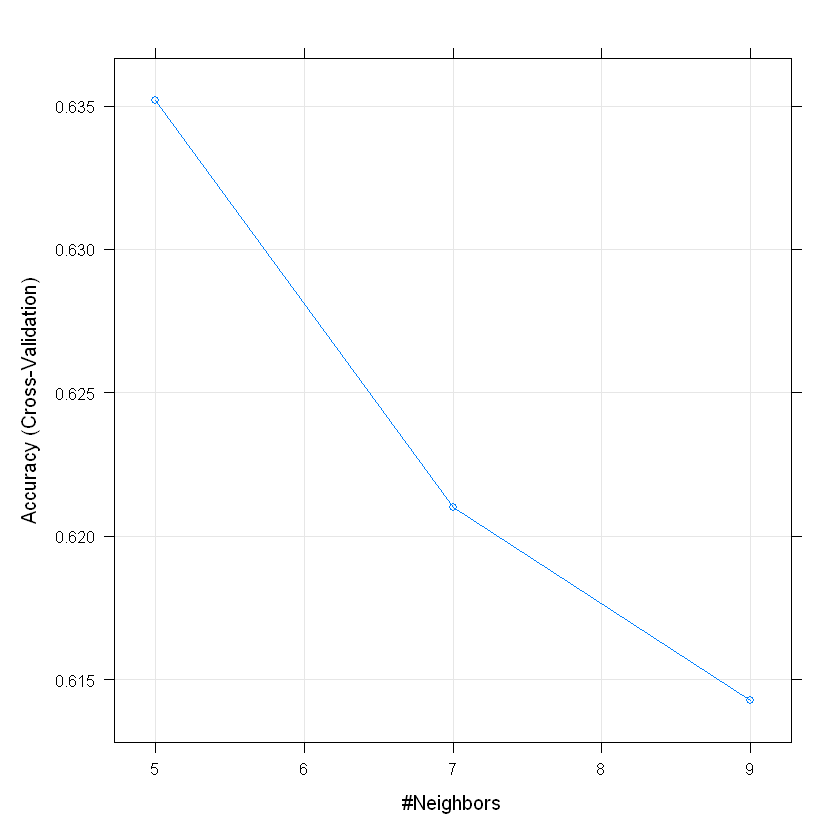

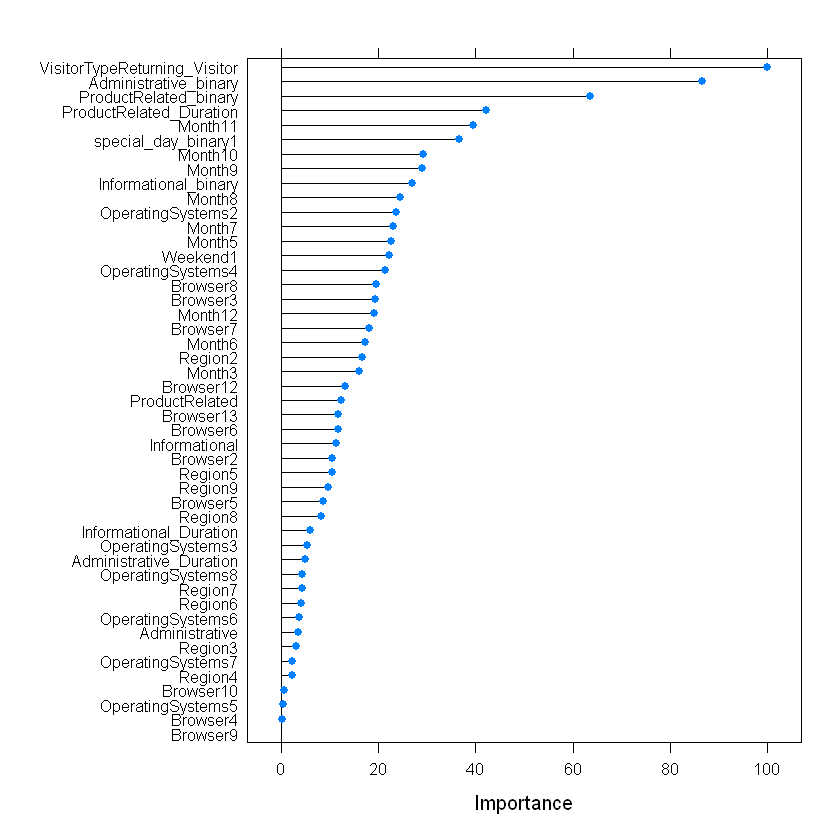

In [40]:
set.seed(1234)
lr_model = train(Revenue ~ ., 
                 family = "binomial",
                 data = r_train,
                 method = "glm", 
                 trControl = trainControl(method = "cv",
                                          number = 5,
                                          sampling = "smote"
                 ),
                 na.action = na.omit)
#k nearest neighbors
set.seed(1234)
default_knn_mod = train(
  Revenue ~ .,
  data = r_train,
  method = "knn",
  trControl = trainControl(method = "cv",number = 5, sampling = "smote")
)
#5
plot(default_knn_mod)
default_knn_mod$results
default_knn_mod$bestTune
predictions_knn = predict(default_knn_mod, newdata = r_test)
confusionMatrix(predictions_knn, r_test$Revenue)

lr_model$results
lr_model$finalModel
summary(lr_model)
predictions = predict(lr_model, newdata = r_test)
confusionMatrix(predictions, r_test$Revenue)
plot(varImp(lr_model))


# Bagged Decision Trees

- Decision Trees didn’t work (no nodes) so I used bagged aggregation
- Accuracy & Sensitivity are decent but Specificity is far too low
- Using number = 5 to match the resamples count for comparison later


Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1991  324
     TRUE     79   54
                                          
               Accuracy : 0.8354          
                 95% CI : (0.8201, 0.8499)
    No Information Rate : 0.8456          
    P-Value [Acc > NIR] : 0.9222          
                                          
                  Kappa : 0.1424          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9618          
            Specificity : 0.1429          
         Pos Pred Value : 0.8600          
         Neg Pred Value : 0.4060          
             Prevalence : 0.8456          
         Detection Rate : 0.8133          
   Detection Prevalence : 0.9457          
      Balanced Accuracy : 0.5523          
                                          
       'Positive' Class : FALSE           
                     

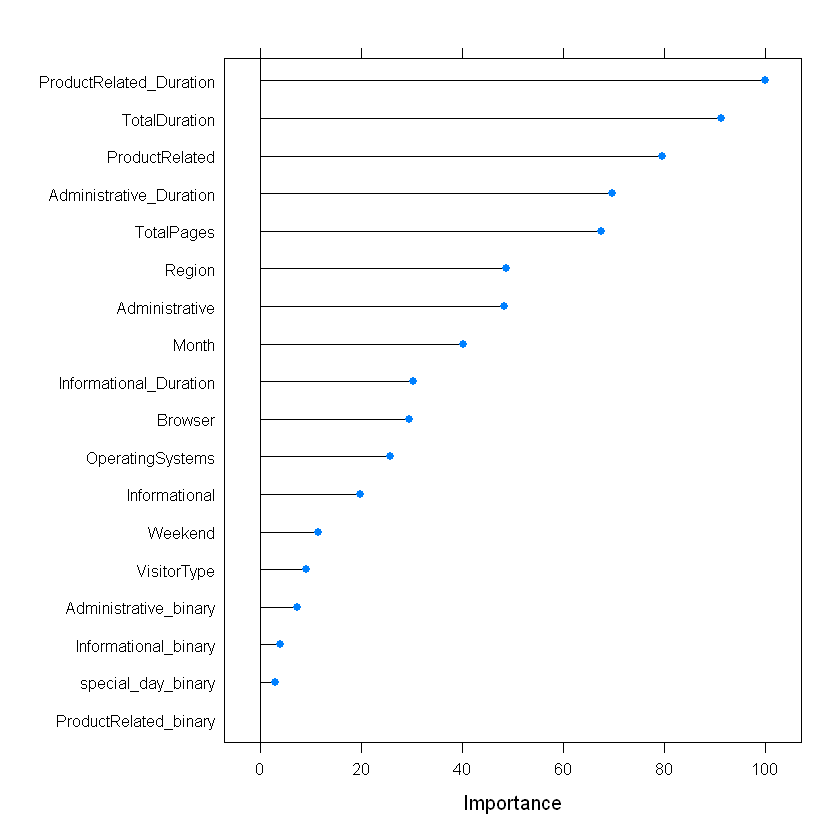

In [41]:
set.seed(1234)
bagged_model = train(y=r_train$Revenue, 
                           trControl = trainControl(method = "cv",
                                                    number = 5),
                          x = training_set, method = "treebag")

bagged_predictions = predict(bagged_model, r_test)
confusionMatrix(bagged_predictions, r_test$Revenue)
plot(varImp(bagged_model))


#specificity is really really bad. Not usable

# Random Forest using Ranger
- Random forest performance was very slow, so I used ranger
- Accuracy & Sensitivity & Specificity are decent 
- Using number = 5 to match the resamples count for comparison later


In [42]:
library(ranger)
set.seed(1234)
features <- setdiff(names(r_train), "Revenue")
x <- r_train[, features]
y <- r_train$Revenue
# set up 5-fold cross validation procedure
train_control <- trainControl(method = "cv",
                              number = 5,
#                              verboseIter = TRUE,
                              savePredictions = "final")
#ran it once without tuneGrid and these were the best params 
rf_grid <- expand.grid(mtry = c(5),
                       splitrule = c("extratrees"),
                       min.node.size = c(2))
rf.model <- train(
                  x = x,
                  y = y,
                  method = "ranger",
                  trControl = train_control,
                  tuneGrid = rf_grid,
                  )
rf.model
rf_predictions = predict(rf.model, r_test)
confusionMatrix(rf_predictions, r_test$Revenue)


Random Forest 

9797 samples
  18 predictor
   2 classes: 'FALSE', 'TRUE' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 7837, 7838, 7837, 7837, 7839 
Resampling results:

  Accuracy   Kappa     
  0.8453614  0.06300724

Tuning parameter 'mtry' was held constant at a value of 5
Tuning
 parameter 'splitrule' was held constant at a value of extratrees

Tuning parameter 'min.node.size' was held constant at a value of 2

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  2044  356
     TRUE     26   22
                                         
               Accuracy : 0.844          
                 95% CI : (0.829, 0.8581)
    No Information Rate : 0.8456         
    P-Value [Acc > NIR] : 0.6017         
                                         
                  Kappa : 0.071          
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.9874         
            Specificity : 0.0582         
         Pos Pred Value : 0.8517         
         Neg Pred Value : 0.4583         
             Prevalence : 0.8456         
         Detection Rate : 0.8350         
   Detection Prevalence : 0.9804         
      Balanced Accuracy : 0.5228         
                                         
       'Positive' Class : FALSE          
                                         

# Compare models

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1323  131
     TRUE    747  247
                                         
               Accuracy : 0.6413         
                 95% CI : (0.622, 0.6604)
    No Information Rate : 0.8456         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1756         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6391         
            Specificity : 0.6534         
         Pos Pred Value : 0.9099         
         Neg Pred Value : 0.2485         
             Prevalence : 0.8456         
         Detection Rate : 0.5404         
   Detection Prevalence : 0.5940         
      Balanced Accuracy : 0.6463         
                                         
       'Positive' Class : FALSE          
                                         

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1396  180
     TRUE    674  198
                                        
               Accuracy : 0.6511        
                 95% CI : (0.6319, 0.67)
    No Information Rate : 0.8456        
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.1292        
                                        
 Mcnemar's Test P-Value : <2e-16        
                                        
            Sensitivity : 0.6744        
            Specificity : 0.5238        
         Pos Pred Value : 0.8858        
         Neg Pred Value : 0.2271        
             Prevalence : 0.8456        
         Detection Rate : 0.5703        
   Detection Prevalence : 0.6438        
      Balanced Accuracy : 0.5991        
                                        
       'Positive' Class : FALSE         
                                        

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  1991  324
     TRUE     79   54
                                          
               Accuracy : 0.8354          
                 95% CI : (0.8201, 0.8499)
    No Information Rate : 0.8456          
    P-Value [Acc > NIR] : 0.9222          
                                          
                  Kappa : 0.1424          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.9618          
            Specificity : 0.1429          
         Pos Pred Value : 0.8600          
         Neg Pred Value : 0.4060          
             Prevalence : 0.8456          
         Detection Rate : 0.8133          
   Detection Prevalence : 0.9457          
      Balanced Accuracy : 0.5523          
                                          
       'Positive' Class : FALSE           
                     

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE  2044  356
     TRUE     26   22
                                         
               Accuracy : 0.844          
                 95% CI : (0.829, 0.8581)
    No Information Rate : 0.8456         
    P-Value [Acc > NIR] : 0.6017         
                                         
                  Kappa : 0.071          
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.9874         
            Specificity : 0.0582         
         Pos Pred Value : 0.8517         
         Neg Pred Value : 0.4583         
             Prevalence : 0.8456         
         Detection Rate : 0.8350         
   Detection Prevalence : 0.9804         
      Balanced Accuracy : 0.5228         
                                         
       'Positive' Class : FALSE          
                                         


Call:
summary.resamples(object = results)

Models: knn, rf.model, lr_model, bagged_model 
Number of resamples: 5 

Accuracy 
                  Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
knn          0.6250000 0.6260204 0.6321429 0.6351980 0.6457376 0.6470889    0
rf.model     0.8433673 0.8433673 0.8453292 0.8453614 0.8464286 0.8483146    0
lr_model     0.6260204 0.6430031 0.6438776 0.6418302 0.6459184 0.6503318    0
bagged_model 0.8319714 0.8352041 0.8357143 0.8357657 0.8362245 0.8397141    0

Kappa 
                   Min.    1st Qu.     Median       Mean    3rd Qu.       Max.
knn          0.08419389 0.09110869 0.09606587 0.10404801 0.11234846 0.13652317
rf.model     0.04349817 0.05166273 0.06621166 0.06300724 0.07192544 0.08173822
lr_model     0.16623141 0.17084928 0.17262904 0.17349252 0.17424869 0.18350416
bagged_model 0.11849837 0.12521012 0.12867548 0.12917009 0.13298879 0.14047771
             NA's
knn             0
rf.model        0
lr_model        0
bagged_mo

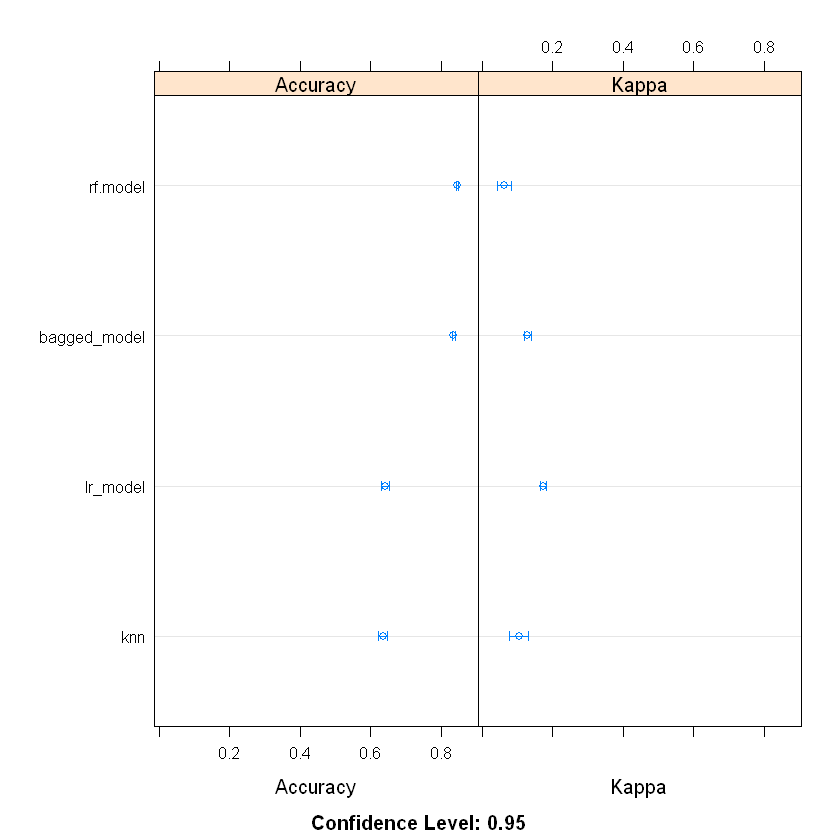

In [31]:
confusionMatrix(predictions, r_test$Revenue)
confusionMatrix(predictions_knn, r_test$Revenue)
confusionMatrix(bagged_predictions, r_test$Revenue)
confusionMatrix(rf_predictions, r_test$Revenue)

results = resamples(list(knn = default_knn_mod, rf.model= rf.model,lr_model = lr_model, bagged_model=bagged_model))
summary(results)
dotplot(results)

# Final Model Selection: Logistic Regression

- Decent Accuracy and Specificity
- Could tune it more to improve accuracy

Let's look at the features of this model


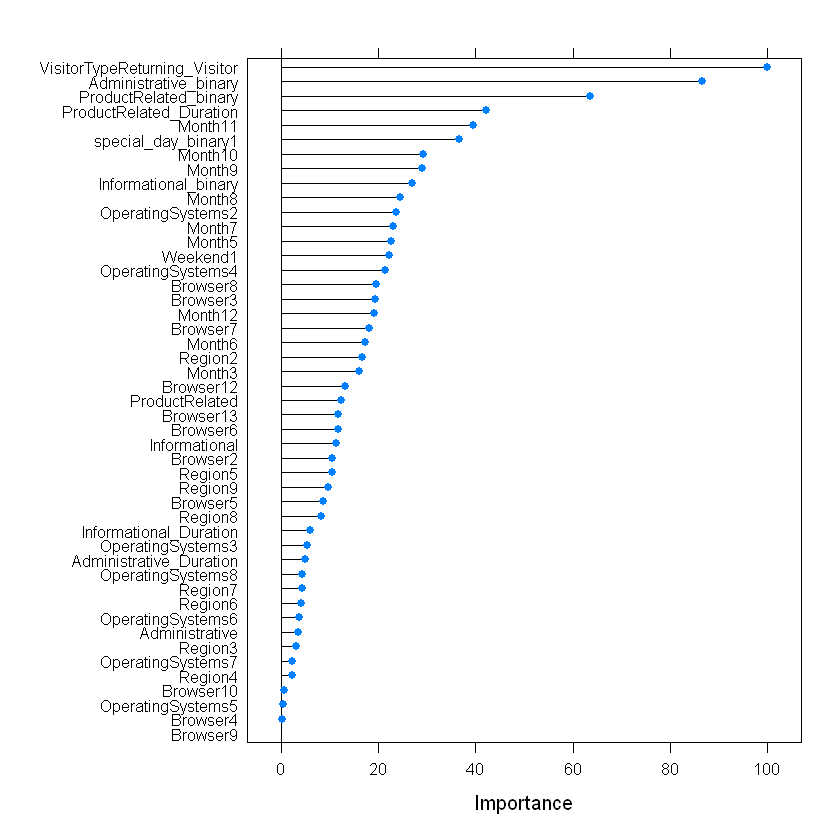

In [43]:
plot(varImp(lr_model))

# Recommendations

Original Hypothesis: Users who spend more time on the site & visit key pages have a higher tendency to convert

#### Attract Return Visitors
- Returning Visitors are more likely to convert, keep targeting them.

#### Campaign Timing
- Special Days and Weekends lead to more conversions, so continue to focus on those initiatives


# Challenges

The models could have been tuned more finely to increase accuracy

Would have wanted to run correlation tests to understand the strength of correlation between returning visitors and conversions. Is it truly the most important feature or is it because there are more total returning users than new?

It would have been helpful to have more data on other variables like acquisition campaigns (where are the users coming from before they land on the site?)

Random Forest and XGBoost Models were slow, so I didn’t get a chance to evaluate those
